In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import scipy.integrate as integrate
import GPy

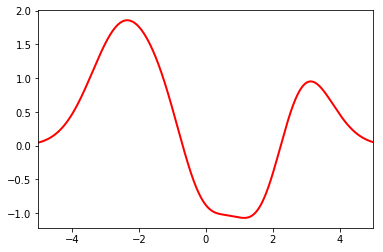

In [2]:
def sample_function(x_range, N=1000, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = GPy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
#     mean = gpy.mappings.Linear(dx, 1)
    mu = np.zeros(x.shape)
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    #import pdb; pdb.set_trace()
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.01

    def f(x): return m.predict(x)[0]
    return f
x_range = np.array([[-2.], [2.]])
f = sample_function(x_range)

def plot_f(f):
    xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
    yy = f(xx)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(-5.0, 5.0)
    plt.show()
plot_f(f)

def plot(m, reff=None):
    xx = np.linspace(-5.0, 5.0, 300).reshape(300, 1)
    mean, std = m.predict(xx,return_std=True)
    mean = mean[:,0]
    plt.plot(xx, mean, 'r', lw=2,label='GP mean')
    plt.fill_between(xx[:, 0],
                     mean - std**2,
                     mean + std**2,
                     color='r', alpha=0.2,label='95% confidence interval')
    plt.xlim(-5.0, 5.0)
    if reff:
        xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
        yy = reff(xx)
        plt.plot(xx, yy, 'b', lw=2,label='ground truth')
        plt.xlim(-5.0, 5.0)
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(3.0)).pdf(s)
print f(np.array([[0]]))
print "Mean Numerical Integration"
integral_value,_ = integrate.quad(lambda x: f(np.array([[x]]))*normal(x),np.NINF,np.inf)
print integral_value

[[-0.878945]]
Mean Numerical Integration
-0.00125149770736


In [5]:
def bintegrate(gp,b,B):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = (z.T).dot(cho_solve((gp.L_, True), gp.y_train_))
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, cho_solve((gp.L_, True), z))
    return mean[0][0], var[0][0], z

def bacquistion(gp,xs,zprev):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    
    for i in range(xs.shape[0]):
        x = xs[i, :]
        Xnew = np.vstack((gp.X_train_, x))
        K = gp.kernel_(Xnew)
        K[np.diag_indices_from(K)] += gp.alpha
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((zprev, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[0]]

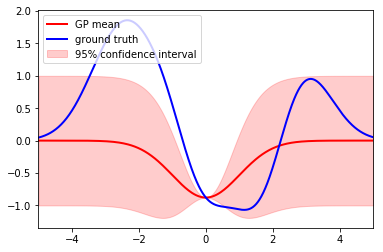

Mean: -0.4394724985714001 , Variance 0.1279644730342273
new sample[[1.86868687]]


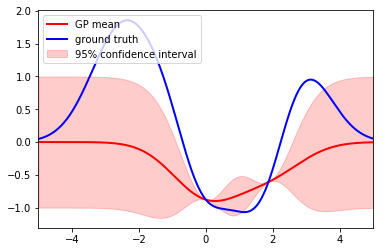

Mean: -0.5507573357109490 , Variance 0.0705626767135828
new sample[[-1.76767677]]


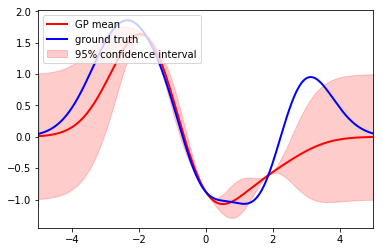

Mean: -0.1040460679143049 , Variance 0.0091833621838640
new sample[[-3.48484848]]


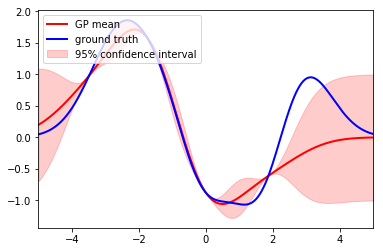

Mean: -0.0740322831216139 , Variance 0.0064751268874093
new sample[[3.68686869]]


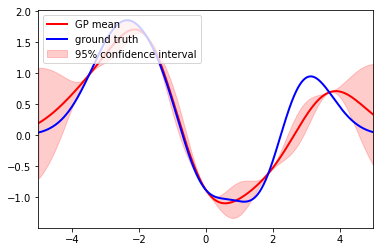

Mean: -0.0396594354517009 , Variance 0.0045806924961227
new sample[[1.26262626]]


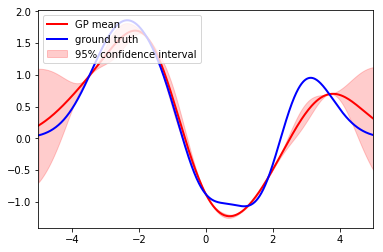

Mean: -0.0526115898047969 , Variance 0.0027616469107452
new sample[[-0.95959596]]


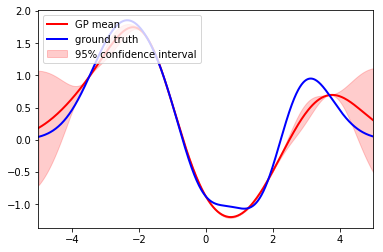

Mean: -0.0624125924503279 , Variance 0.0010895463472394
new sample[[2.27272727]]


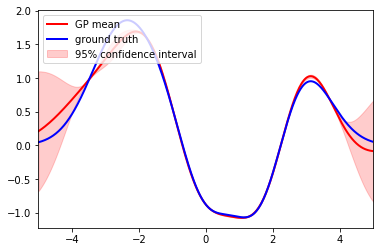

Mean: -0.0184495039867691 , Variance 0.0003690952345221
new sample[[-2.47474747]]


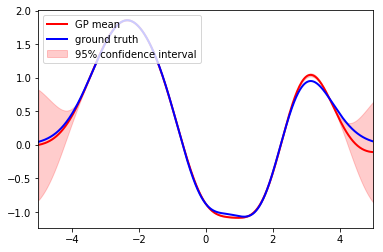

Mean: -0.0044228654290510 , Variance 0.0000714069676862
new sample[[-4.8989899]]


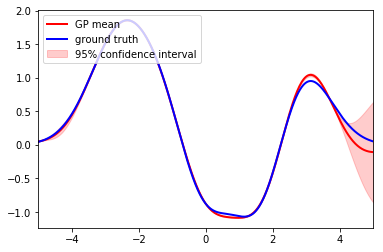

Mean: -0.0040949198808873 , Variance 0.0000370837243256
new sample[[0.45454545]]


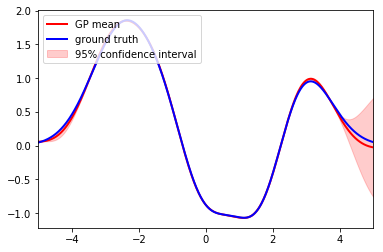

Mean: -0.0013185184150926 , Variance 0.0000172030420044
new sample[[5.]]


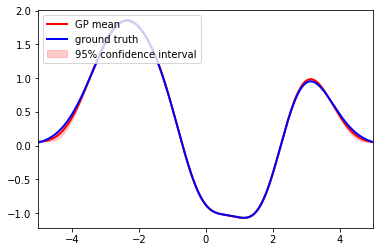

Mean: -0.0009956099621995 , Variance 0.0000046926199422
new sample[[3.18181818]]


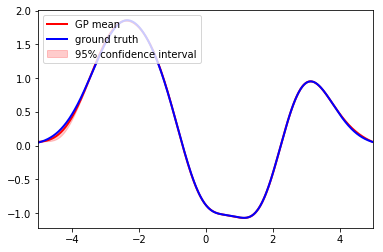

Mean: -0.0015558027271716 , Variance 0.0000013846471495
new sample[[-3.98989899]]


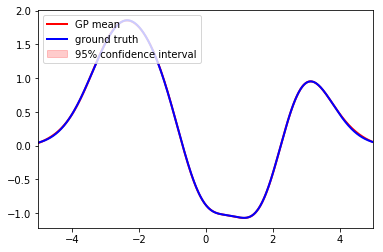

Mean: -0.0013818724251315 , Variance 0.0000008411533339
new sample[[-0.05050505]]


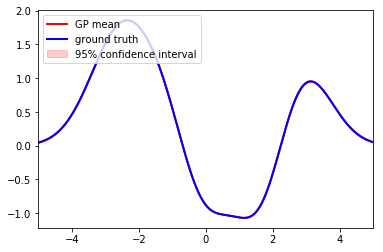

Mean: -0.0012181300133705 , Variance 0.0000006471955759
new sample[[3.58585859]]


 /Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


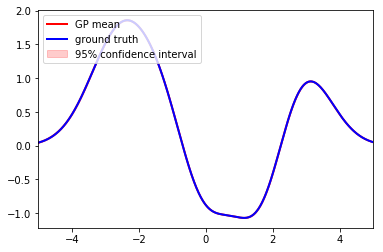

Mean: -0.0012216394513231 , Variance 0.0000004662532987
new sample[[-2.17171717]]


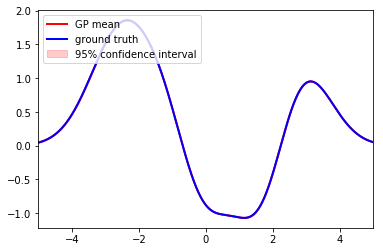

Mean: -0.0012497573178791 , Variance 0.0000003013515082
new sample[[-5.]]


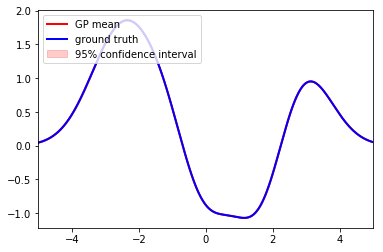

Mean: -0.0012499456756814 , Variance 0.0000002296562080
new sample[[-4.7979798]]


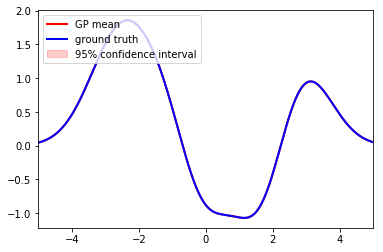

Mean: -0.0012501588120131 , Variance 0.0000001343068640
new sample[[4.8989899]]


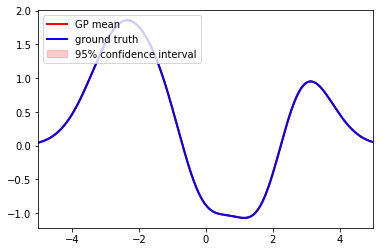

Mean: -0.0012529093540548 , Variance 0.0000000797092223
new sample[[4.7979798]]


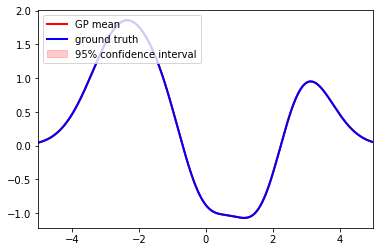

Mean: -0.0012506708831654 , Variance 0.0000000362892887
new sample[[4.5959596]]


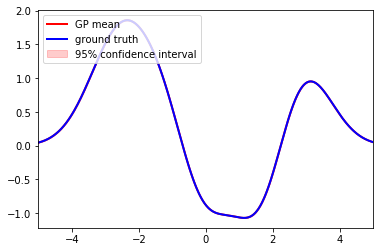

Mean: -0.0012516832076588 , Variance 0.0000000238477296
new sample[[-4.6969697]]


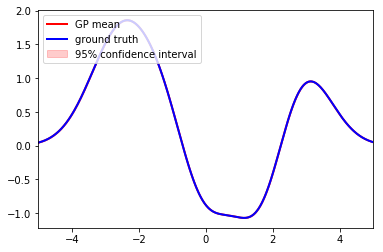

Mean: -0.0012517482210370 , Variance 0.0000000175976604
new sample[[-3.58585859]]


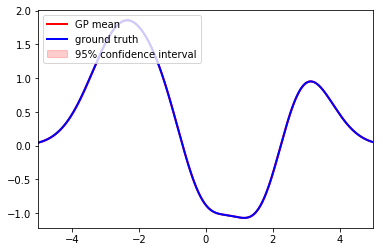

Mean: -0.0012518059226352 , Variance 0.0000000149440786
new sample[[3.98989899]]


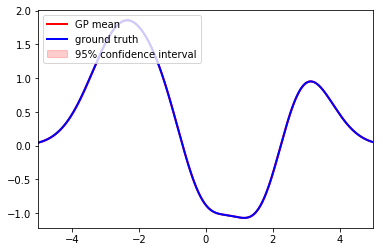

Mean: -0.0012515253208250 , Variance 0.0000000131479673
new sample[[-4.5959596]]


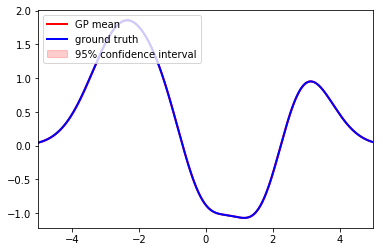

Mean: -0.0012515364724806 , Variance 0.0000000121252818
new sample[[-2.77777778]]


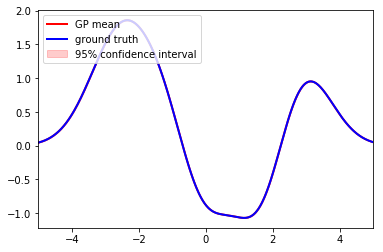

Mean: -0.0012514884196122 , Variance 0.0000000116645847
new sample[[4.8989899]]


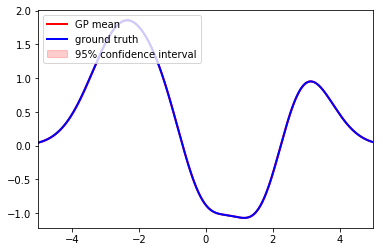

Mean: -0.0012514781453525 , Variance 0.0000000114039506
new sample[[4.7979798]]


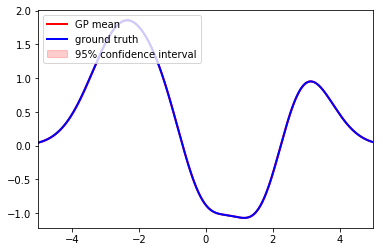

Mean: -0.0012514657889053 , Variance 0.0000000111360812
new sample[[-0.25252525]]


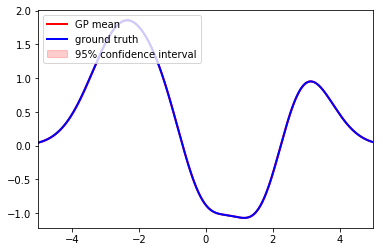

Mean: -0.0012514839253637 , Variance 0.0000000108771092
[(0.43822100086404114, 0.12796447303422726), (0.54950583800359, 0.0705626767135828), (0.10279457020694592, 0.009183362183864008), (0.07278078541425485, 0.00647512688740931), (0.03840793774434188, 0.004580692496122696), (0.05136009209743787, 0.002761646910745208), (0.061161094742968866, 0.0010895463472394007), (0.017198006279410136, 0.0003690952345221099), (0.003171367721692006, 7.140696768620503e-05), (0.0028434221735282733, 3.7083724325592815e-05), (6.702070773355329e-05, 1.720304200436562e-05), (0.00025588774515951374, 4.6926199421815085e-06), (0.00030430501981258684, 1.384647149549334e-06), (0.0001303747177725384, 8.411533339303112e-07), (3.336769398855355e-05, 6.471955758535763e-07), (2.985825603586678e-05, 4.662532987476098e-07), (1.7403894798789787e-06, 3.013515081917717e-07), (1.5520316776346244e-06, 2.2965620799508812e-07), (1.3388953459397834e-06, 1.3430686401916248e-07), (1.4116466957453389e-06, 7.970922227817923e-08), (

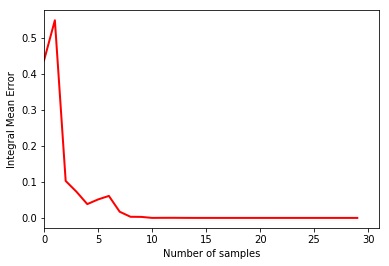

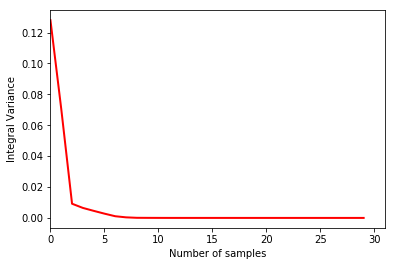

In [6]:
# WITH BAYESIAN QUADRATURE

yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    if i>0:
        xs = np.atleast_2d(np.linspace(-5,5,100)).T
        newx = bacquistion(gp,xs,zprev).reshape((1,-1))
        print "new sample" + str(newx)
        x = np.vstack((x, newx))
        y = f(x)
    else:
        x = np.atleast_2d(np.linspace(0,0,1)).T
        y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')

ITERATION: 0


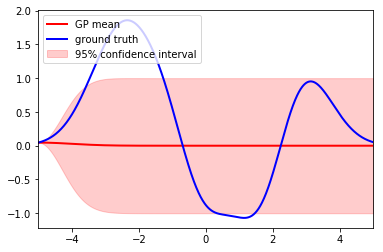

Mean: 0.0010182589697252 , Variance 0.3774818594752186
ITERATION: 1


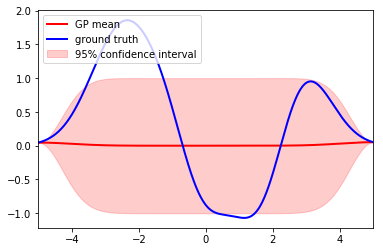

Mean: 0.0021635280252591 , Variance 0.3769992459412099
ITERATION: 2


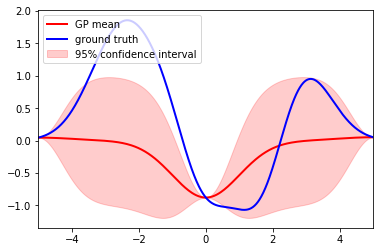

Mean: -0.4373090101484724 , Variance 0.1269994096969521
ITERATION: 3


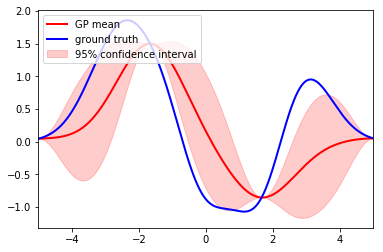

Mean: 0.2295460911512301 , Variance 0.1284007128616954
ITERATION: 4


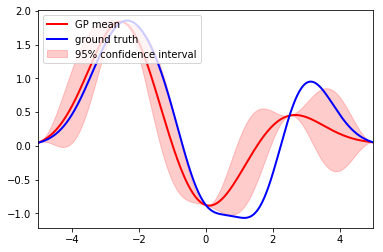

Mean: 0.0513740338202331 , Variance 0.0416473703921365
ITERATION: 5


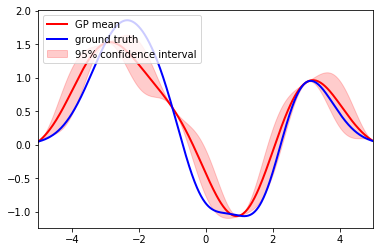

Mean: 0.0795558142675753 , Variance 0.0104692326227099
ITERATION: 6


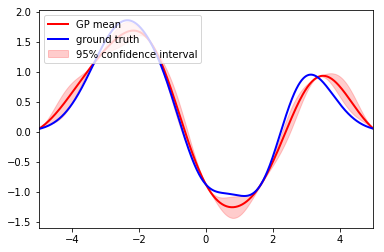

Mean: -0.0486863476763227 , Variance 0.0016823711313458
ITERATION: 7


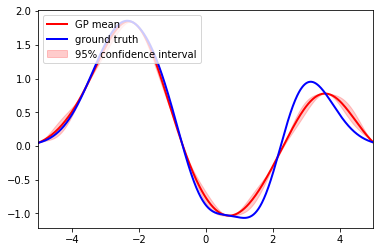

Mean: 0.0201261236850647 , Variance 0.0001891496287459
ITERATION: 8


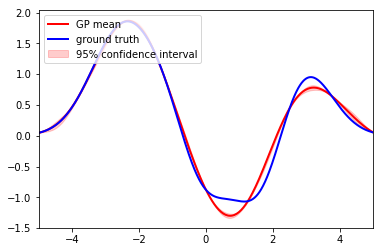

Mean: -0.0048464466955629 , Variance 0.0000152707084076
ITERATION: 9


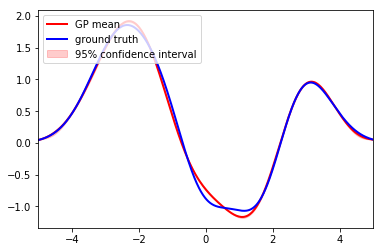

Mean: -0.0008397495587764 , Variance 0.0000012126527427
ITERATION: 10


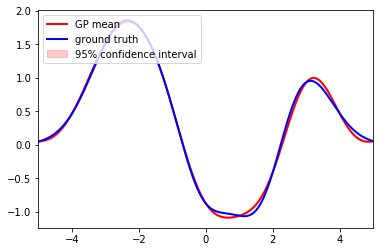

Mean: -0.0011440612986302 , Variance 0.0000004449550693
ITERATION: 11


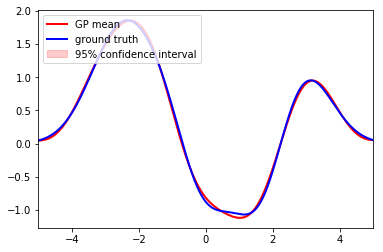

Mean: -0.0011285630155350 , Variance 0.0000004290671043
ITERATION: 12


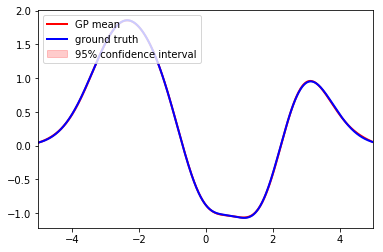

Mean: -0.0013170356684143 , Variance 0.0000004146981718
ITERATION: 13


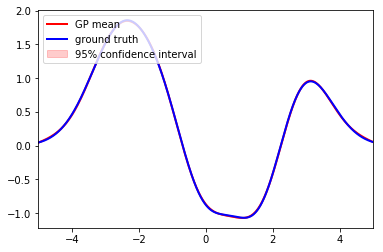

Mean: -0.0013688600218294 , Variance 0.0000003944812194
ITERATION: 14


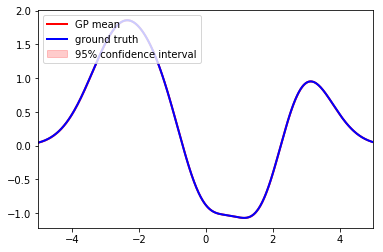

Mean: -0.0012499618448116 , Variance 0.0000003507659872
ITERATION: 15


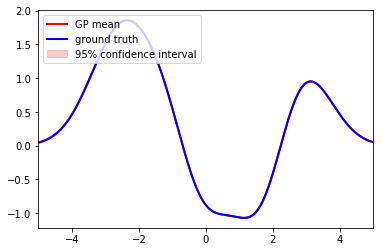

Mean: -0.0012150644729122 , Variance 0.0000003185263208
ITERATION: 16


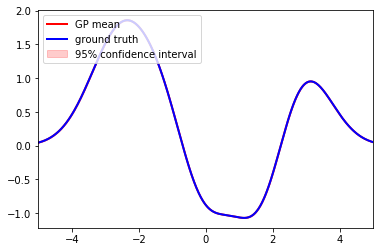

Mean: -0.0012456583078406 , Variance 0.0000002668746811
ITERATION: 17


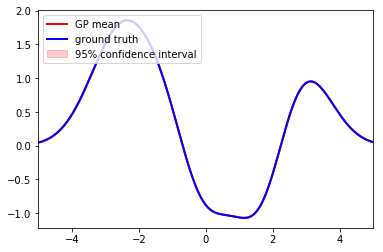

Mean: -0.0012543550175649 , Variance 0.0000002366269509
ITERATION: 18


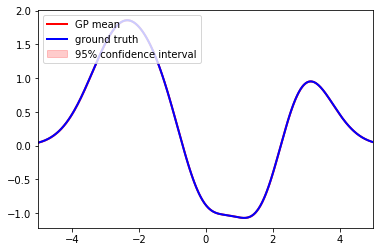

Mean: -0.0012529997692838 , Variance 0.0000001894794241
ITERATION: 19


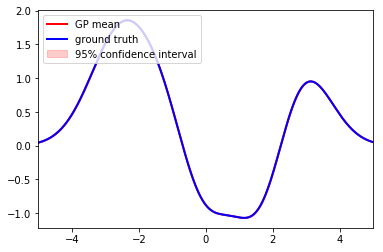

Mean: -0.0012524110629499 , Variance 0.0000001660736825
ITERATION: 20


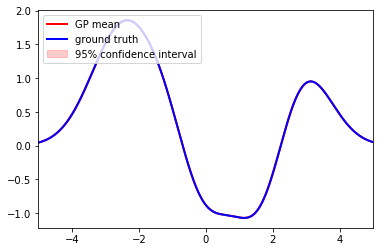

Mean: -0.0012514056190483 , Variance 0.0000001282373430
ITERATION: 21


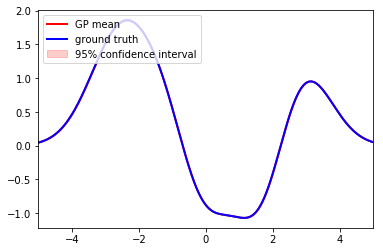

Mean: -0.0012512539783245 , Variance 0.0000001118812551
ITERATION: 22


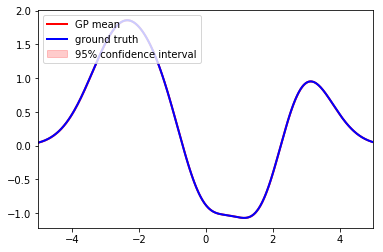

Mean: -0.0012514755012555 , Variance 0.0000000839810941
ITERATION: 23


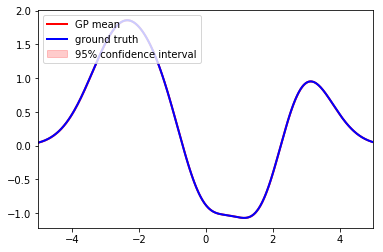

Mean: -0.0012515122568384 , Variance 0.0000000731785014
ITERATION: 24


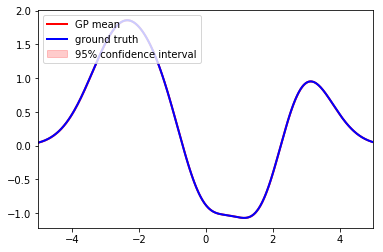

Mean: -0.0012515088165656 , Variance 0.0000000564069377
ITERATION: 25


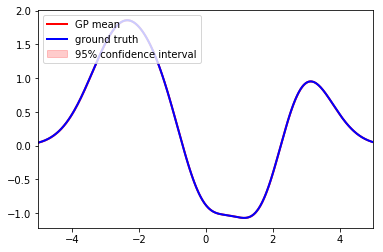

Mean: -0.0012515049258017 , Variance 0.0000000482800904
ITERATION: 26


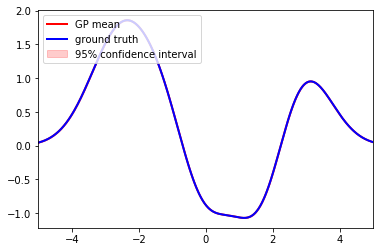

Mean: -0.0012515015272716 , Variance 0.0000000423411484
ITERATION: 27


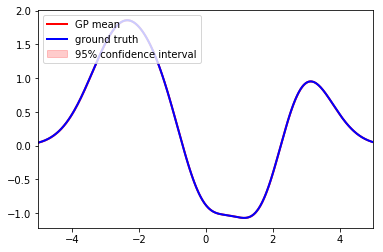

Mean: -0.0012514989523922 , Variance 0.0000000374964297
ITERATION: 28


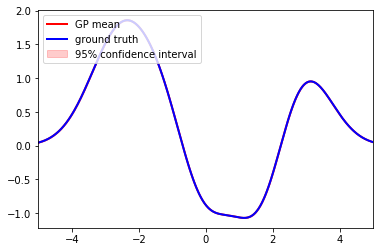

Mean: -0.0012514972144947 , Variance 0.0000000334872750
ITERATION: 29


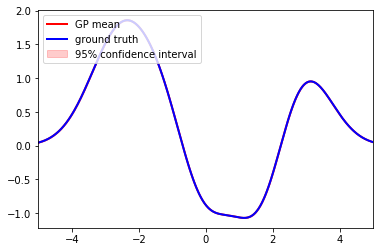

Mean: -0.0012514961461477 , Variance 0.0000000301945014
[(0.0022697566770841946, 0.37748185947521856), (0.0034150257326180924, 0.3769992459412099), (0.4360575124411134, 0.12699940969695211), (0.23079758885858914, 0.12840071286169535), (0.052625531527592084, 0.04164737039213651), (0.0808073119749343, 0.010469232622709879), (0.04743484996896371, 0.001682371131345839), (0.021377621392423732, 0.00018914962874594377), (0.0035949489882038527, 1.5270708407566502e-05), (0.0004117481485826288, 1.2126527426659095e-06), (0.00010743640872881016, 4.4495506928976525e-07), (0.00012293469182399208, 4.2906710429058137e-07), (6.553796105533694e-05, 4.1469817180228574e-07), (0.00011736231447036227, 3.944812193568126e-07), (1.5358625473681567e-06, 3.5076598720040764e-07), (3.6433234446825447e-05, 3.1852632081941223e-07), (5.839399518370314e-06, 2.6687468113184565e-07), (2.8573102059149813e-06, 2.3662695092241393e-07), (1.5020619247570026e-06, 1.8947942409530683e-07), (9.133555909229818e-07, 1.660736825281

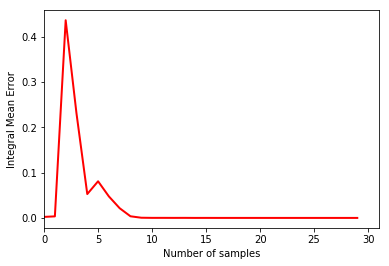

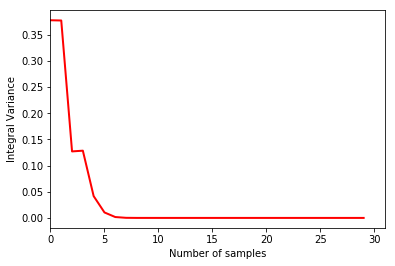

In [7]:
yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    print "ITERATION: %d" % i
    x = np.atleast_2d(np.linspace(-5,5,i+1)).T
    y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')